In [62]:
import os
import csv
import pandas as pd
import time
import pickle
import sys
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict


In [63]:
print(os.getcwd())
# it should end with this: /AITutor_SeqModeling
# if not, run the next block


/


In [64]:
# run if the current directory is not AITutor_SeqModeling
cwd = os.chdir(os.path.join(os.getcwd(), ".."))
print(os.getcwd())

/


In [65]:
# download the groups as a set
a = pd.read_csv("data/Groups.csv")
valid_ids = set(a["id"].values)
len(valid_ids)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Groups.csv'

In [5]:
File_pickle = "data/KT_logs_annotated.pkl"

# read from pickle
df = pd.read_pickle(File_pickle)

df.head()

,username,skill,correct,time
0,a1,"[Supervised Learning, Classification Algorithms]",True,0.000000
1,a1,"[Supervised Learning, Classification Algorithms]",False,3.726700
2,a2,"[Supervised Learning, Classification Algorithms]",False,0.000000
3,a2,"[Supervised Learning, Classification Algorithms]",True,1.987467
4,a3,"[Supervised Learning, Classification Algorithms]",True,0.000000


In [6]:
# get the number of unique usernames
len(df["username"].unique())

93

In [7]:
# get rid of entries where username is not in the valid_ids
df = df[df["username"].isin(valid_ids)]
len(df["username"].unique())

89

In [8]:
skills = pickle.load(open("data/Skill_hirereachy.pkl", "rb"))

In [9]:
# version 1: Only user params
# user_params = {}

# def initialize_user_params(user_id, skills):
#     user_params[user_id] = {}
#     for skill in skills.keys():
#         skill_params = skills[skill][-1]
#         user_params[user_id][skill] = {
#             "P(L)": skill_params[0],
#             "P(T)": skill_params[1],
#             "P(G)": skill_params[2],
#             "P(S)": skill_params[3]
#         }
# for user_id in df["username"].unique():
#     initialize_user_params(user_id, skills)

In [10]:
# version 2: seperate user-specific and skill specific parameters
def initialize_params(skills):
    skill_params = {}
    for skill in skills.keys():
        skill_params[skill] = {
                "P(L)": skills[skill][-1][0],
                "P(T)": skills[skill][-1][1],
                "P(G)": skills[skill][-1][1],
                "P(S)": skills[skill][-1][3]
            }
    return skill_params

In [11]:
skill_params = initialize_params(skills)

In [12]:
# Function to compute P(C_t|L_t, G, S)
def compute_prob_correctness(P_L, P_G, P_S, P_T, correct):
    if correct:
        P_L_obs = P_L* (1 - P_S) /((1 - P_S) * P_L + P_G * (1 - P_L))
    else:
        P_L_obs = P_L* (P_S) /(P_S * P_L + (1 - P_G) * (1 - P_L))
    
    P_L_new = P_L_obs + (1 - P_L_obs) * P_T
    P_C = P_L_new * (1 - P_S) + (1 - P_L_new) * P_G

    # debug
    if not (0 <= P_C <= 1):
        print(f"Invalid P(C): {P_C}, P_L: {P_L}, P_G: {P_G}, P_S: {P_S}, P_T: {P_T}")
    return P_C, P_L_new


In [13]:
def compute_gradients(P_tuple, correct):

    P_L, P_G, P_S, P_T = P_tuple
    if correct:
        dP_L_obs_dP_L = (1 - P_S) * ((1 - P_S) - P_G) / (((1 - P_S) * P_L + P_G * (1 - P_L)) ** 2)
    else:
        dP_L_obs_dP_L = P_S * (P_S - (1 - P_G)) / ((P_S * P_L + (1 - P_G) * (1 - P_L)) ** 2)

    P_L_obs = P_L * P_S / (P_S * P_L + (1 - P_G) * (1 - P_L))
    P_L_new = P_L_obs + (1 - P_L_obs) * P_T
    
    
    dP_L_new_dP_L = dP_L_obs_dP_L * (1 - P_T)
    dP_C_dP_L = dP_L_new_dP_L * (1 - P_S) - dP_L_new_dP_L * P_G

    dP_L_new_dP_T = 1 - (P_L_obs if correct else 0)
    dP_C_dP_T = dP_L_new_dP_T * (1 - P_S) - dP_L_new_dP_T * P_G

    dP_C_dP_G = (1 - P_L_new) - P_L_new
    dP_C_dP_S = -P_L_new + P_G * (1 - P_L_new)

    return dP_C_dP_L, dP_C_dP_T, dP_C_dP_G, dP_C_dP_S

In [14]:
eps = 1e-9

In [27]:
def log_likelihood(interaction_log, skill_params):
    log_likelihood = 0
    expectations = []
    skill_counts = defaultdict(int)
    for _, row in interaction_log.iterrows():
        user_id = row["username"]
        skill_list = row["skill"]
        correctness = row["correct"]

        for skill in skill_list:

            P_L = skill_params[skill]["P(L)"]
            P_G = skill_params[skill]["P(G)"]
            P_S = skill_params[skill]["P(S)"]
            P_T = skill_params[skill]["P(T)"]

            # update skill and user counts
            skill_counts[skill] += 1

            prob, _ = compute_prob_correctness(P_L, P_G, P_S, P_T, correctness)
            log_likelihood += np.log(prob + eps)
            expectations.append((user_id, skill, prob, correctness, (P_L, P_G, P_S, P_T)))

    return -log_likelihood, expectations, skill_counts

In [79]:
def track_grads(interaction_log, skill_params):
    skill_grads = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
    loss = 0
    log = {}
    log["skill"] = defaultdict(list)
    likelihood, expectations, skill_counts = log_likelihood(interaction_log, skill_params)
    if np.isnan(likelihood):
        print("Log-likelihood NaN detected! Check parameter updates.")

    for user_id, skill, prob, correctness,  P_tuple  in expectations:
        log["skill"][skill].append(prob)
        dP_C_dP_L, dP_C_dP_T, dP_C_dP_G, dP_C_dP_S = compute_gradients(P_tuple, correctness)
        grad = (correctness - prob) / (prob + eps)
        loss += (correctness - prob) ** 2

    

        # Update skill-specific gradients
        normalizing_factor = skill_counts[skill]
        skill_grads[skill]["P(L)"] += grad   / normalizing_factor
        skill_grads[skill]["P(G)"] += grad  / normalizing_factor
        skill_grads[skill]["P(S)"] += grad  / normalizing_factor
        skill_grads[skill]["P(T)"] += grad  / normalizing_factor

        
    

    return skill_grads, likelihood, loss, log

In [17]:
# Parent-Child Constraints
def enforce_constraints( skill_params, skills):
    for skill, skill_data in skills.items():
        parents = skill_data[1]
        for parent in parents:
            if skill_params[skill]["P(L)"] >= skill_params[parent]["P(L)"]:
                skill_params[skill]["P(L)"] = skill_params[parent]["P(L)"] - 0.01 

In [18]:
# Projection
def project_params(params, par_type):
    for key, param_set in params.items():
        if par_type == "skill":
            for param in param_set:
                params[key][param] = np.clip(params[key][param], 0, 1)
        else:
            raise ValueError("Invalid parameter type. Must be 'user' or 'skill'.")
            
    return params

In [69]:
# Update parameters
def update_params(skill_params, skill_grads, learning_rate=0.01):
    output = defaultdict(list) # for plotting

    # Apply batch updates for skill-specific parameters
    for skill, grads in skill_grads.items():
        for param, grad in grads.items():
            skill_params[skill][param] = np.clip(skill_params[skill][param] + learning_rate * grad , 0, 1)

            
    # logging
    output["P(L)"] = [skill_params[skill]["P(L)"] for skill in skill_params.keys()]

    return skill_params, output

In [24]:
def run_sgd(interaction_log, skills, max_iter, learning_rate):
    skill_params = initialize_params(skills)
    log =defaultdict(list)
    pt = 0

    for i in range(max_iter):
        log["iteration"].append(i)
        skill_grads, likelihood, loss, out_e = track_grads(interaction_log, skill_params)
        # decrease the learning rate to half after every 40 iterations
        pt += 1
        if i>10 and pt>5 and loss > log["loss"][-1]:
            pt = 0
            learning_rate /= 2
            print(f"Learning rate halved")
        skill_params, out_m = update_params(skill_params, skill_grads,learning_rate=learning_rate)
        log["P_L"].append(out_m["P_L"])
        log["likelihood"].append(likelihood)
        log["loss"].append(loss)
        log["E_skill"].append(out_e["skill"])
        skill_params = project_params(skill_params, "skill")
        if i % 5 == 0:
            print(f"Iteration {i + 1}, Log-likelihood: {likelihood}, Loss: {loss}")

    return skill_params, log

In [25]:
# randomly select 80% of ids for training from  df["username"].unique()
ids = list(df["username"].unique())
np.random.seed(42)
train_ids = np.random.choice(ids, int(0.85*len(ids)), replace=False)
# slect the rest for testing
test_ids = [i for i in ids if i not in train_ids]

# create df for training and testing
train_df = df[df["username"].isin(train_ids)]
test_df = df[df["username"].isin(test_ids)]

Iteration 1, Log-likelihood: 16589.007459267952, Loss: 1940.221905812701
Iteration 6, Log-likelihood: 17268.014544123278, Loss: 1850.82698968276
Iteration 11, Log-likelihood: 18029.59919632342, Loss: 1764.3498844068736
Iteration 16, Log-likelihood: 18901.558612247685, Loss: 1680.916963070936
Iteration 21, Log-likelihood: 19905.65725891159, Loss: 1603.7854805021318
Iteration 26, Log-likelihood: 21118.463326071393, Loss: 1530.933026987498
Iteration 31, Log-likelihood: 22781.609138388787, Loss: 1462.55976701833
Iteration 36, Log-likelihood: 33780.46270990079, Loss: 1398.2757500453242
Iteration 41, Log-likelihood: 53561.97633748614, Loss: 1338.2306027422899
Iteration 46, Log-likelihood: 57248.36412043876, Loss: 1280.77398231407
Iteration 51, Log-likelihood: 65516.315213761314, Loss: 1225.702480035078
Iteration 56, Log-likelihood: 66621.0143618773, Loss: 1171.9618924372714
Iteration 61, Log-likelihood: 68381.61719394954, Loss: 1119.6120362907454
Iteration 66, Log-likelihood: 78462.822217348

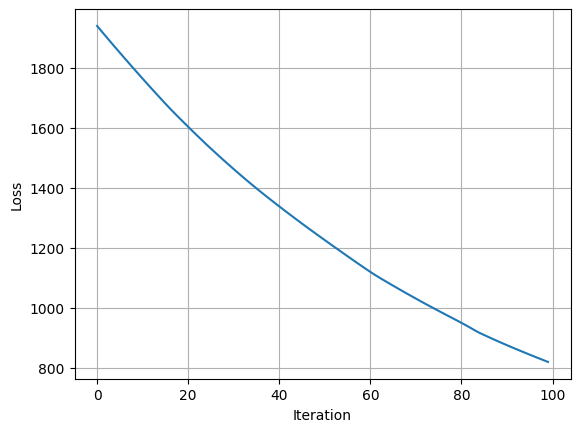

In [87]:
# Run the EM Algorithm
skill_params, log = run_sgd(train_df.iloc[:], skills, max_iter=100, learning_rate=2e-3 )


plt.figure()
plt.plot(log["iteration"], log["loss"])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [88]:
# Output Results
print("Final Skill Parameters:")
for skill, params in skill_params.items():
    print(skill, params)


Final Skill Parameters:
Data Loading {'P(L)': 0.5756087844906831, 'P(T)': 0.46318279418990776, 'P(G)': 0.46318279418990776, 'P(S)': 0.4053026011151606}
Data Cleaning {'P(L)': 0.4458865003910399, 'P(T)': 0.32294705653332806, 'P(G)': 0.32294705653332806, 'P(S)': 0.21182739966945235}
Handling Missing Data {'P(L)': 0.18043068708382193, 'P(T)': 0.12311811294436698, 'P(G)': 0.12311811294436698, 'P(S)': 0.0}
Feature Scaling {'P(L)': 0.15923619049502655, 'P(T)': 0.04005216476211712, 'P(G)': 0.04005216476211712, 'P(S)': 0.0}
Exploratory Data Analysis (EDA) {'P(L)': 0.23500607450915575, 'P(T)': 0.21630992315971523, 'P(G)': 0.21630992315971523, 'P(S)': 0.0}
Statistical Summaries {'P(L)': 0.15117302113792985, 'P(T)': 0.09135309513258301, 'P(G)': 0.09135309513258301, 'P(S)': 0.0}
Visualization {'P(L)': 0.19063004651543153, 'P(T)': 0.08904741460807834, 'P(G)': 0.08904741460807834, 'P(S)': 0.0}
Correlation Analysis {'P(L)': 0.061558426771099795, 'P(T)': 0.0, 'P(G)': 0.0, 'P(S)': 0.0}
Data Splitting {

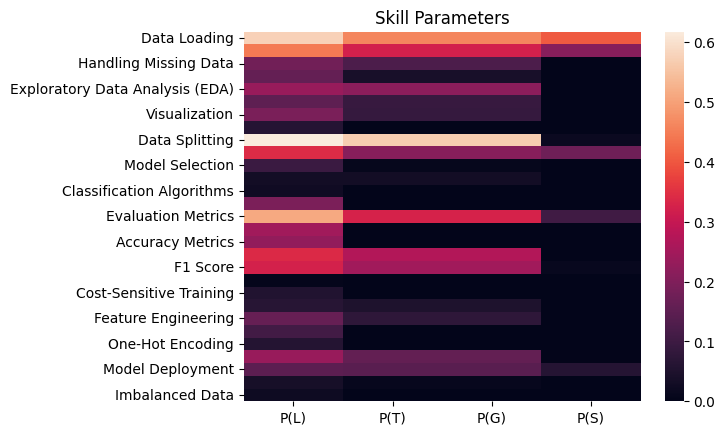

In [89]:
# create heatmap for the skill set parameter
skill_df = pd.DataFrame(skill_params).T
sns.heatmap(skill_df, annot=False)
plt.title("Skill Parameters")
plt.show()

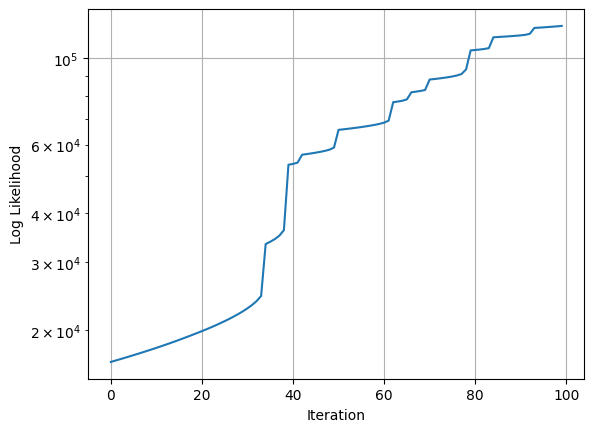

In [90]:
# plot the log likelihood in log scale
plt.figure()
plt.plot(log["iteration"], log["likelihood"])
plt.yscale('log')
plt.grid()
plt.ylabel('Log Likelihood')
plt.xlabel('Iteration')
plt.show()


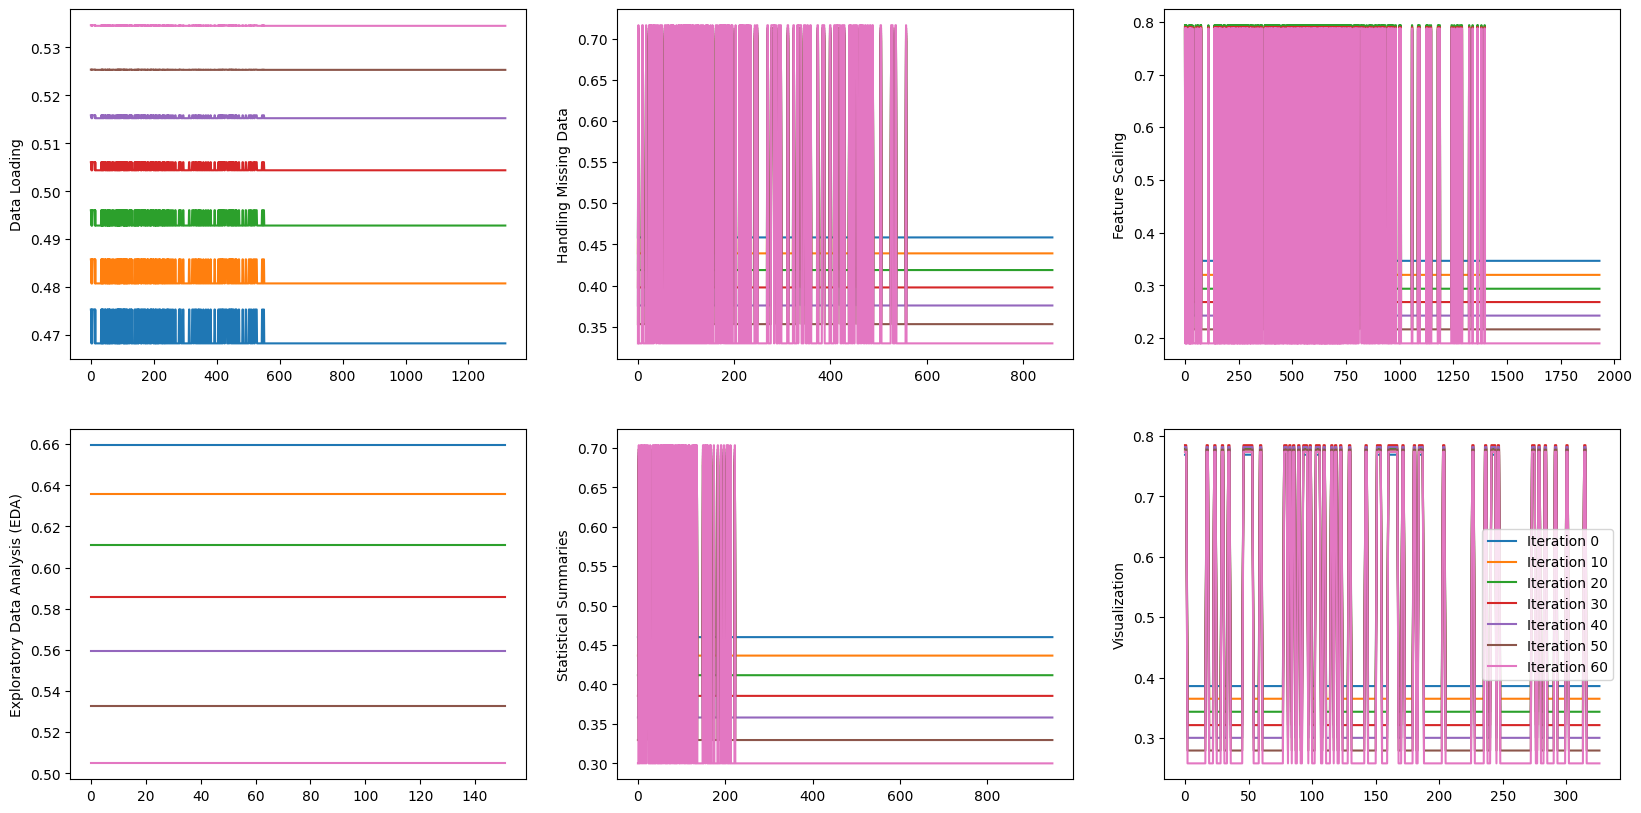

In [91]:
# plot 6 skill over time for different iterations
plt.figure(figsize=(20, 10))
for i in range(0, 70, 10):
    plt.subplot(2, 3, 1)
    skill1 = list(skill_params.keys())[0]
    plt.plot(log["E_skill"][i][skill1])
    plt.ylabel(skill1)
    plt.subplot(2, 3, 2)
    skill2 = list(skill_params.keys())[2]
    plt.plot(log["E_skill"][i][skill2])
    plt.ylabel(skill2)
    plt.subplot(2, 3, 3)
    skill3 = list(skill_params.keys())[3]
    plt.plot( log["E_skill"][i][skill3])
    plt.ylabel(skill3)
    plt.subplot(2, 3, 4)
    skill4 = list(skill_params.keys())[4]
    plt.plot( log["E_skill"][i][skill4])
    plt.ylabel(skill4)
    plt.subplot(2, 3, 5)
    skill5 = list(skill_params.keys())[5]
    plt.plot( log["E_skill"][i][skill5])
    plt.ylabel(skill5)
    plt.subplot(2, 3, 6)
    skill6 = list(skill_params.keys())[6]
    plt.plot( log["E_skill"][i][skill6], label = f"Iteration {i}")
    plt.ylabel(skill6)
plt.legend()
plt.show()

In [92]:
def test_log_likelihood(interaction_log_test, skill_params):
    log_likelihood = 0
    results = []
    error_skill = defaultdict(float)
    count_skill = defaultdict(int)
    error_user = defaultdict(float)
    count_user = defaultdict(int)
    for _, row in interaction_log_test.iterrows():
        user_id = row["username"]
        skill_list = row["skill"]
        correctness = row["correct"]

        for skill in skill_list:

            P_L = skill_params[skill]["P(L)"]
            P_G = skill_params[skill]["P(G)"]
            P_S = skill_params[skill]["P(S)"]
            P_T = skill_params[skill]["P(T)"]

            prob, P_L_new = compute_prob_correctness(P_L, P_G, P_S, P_T, correctness)
            log_likelihood += np.log(prob + eps)
            results.append((user_id, skill, prob, correctness, P_L_new))
            error_skill[skill] += (correctness - prob) ** 2
            count_skill[skill] += 1
            error_user[user_id] += (correctness - prob) ** 2
            count_user[user_id] += 1
   
    for skill in error_skill.keys():
        error_skill[skill] /= count_skill[skill]

    for user_id in error_user.keys():
        error_user[user_id] /= count_user[user_id]

    return -log_likelihood, results, error_skill, error_user

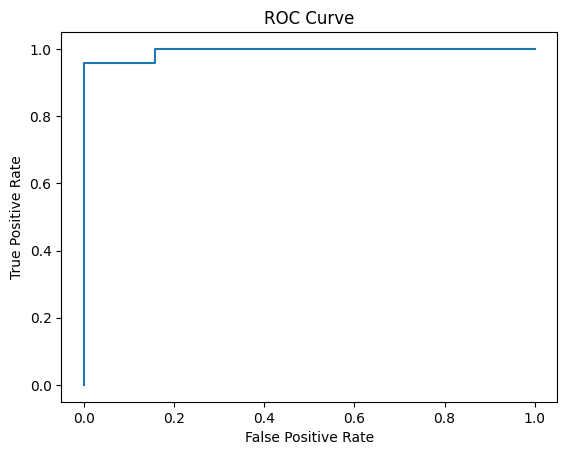

Predicted     0    1
Actual              
False      1641  307
True          0  388
AUC: 0.9935011325387921


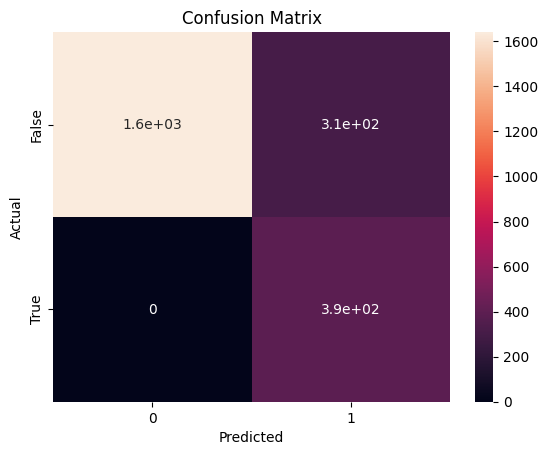

Accuracy: 0.8685787671232876
Precision: 1.0
Recall: 0.5582733812949641
F1 Score: 0.716528162511542
MSE:  0.06440741981457426


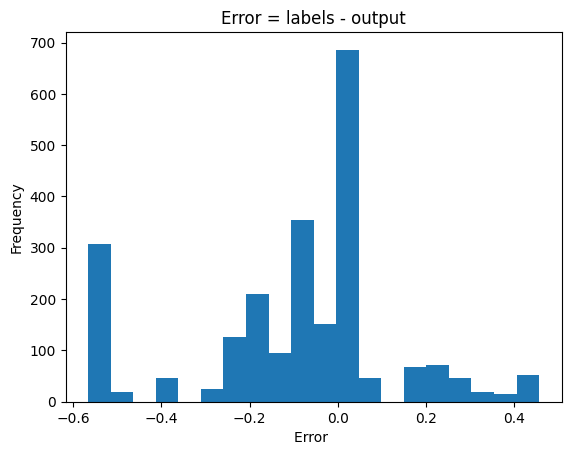

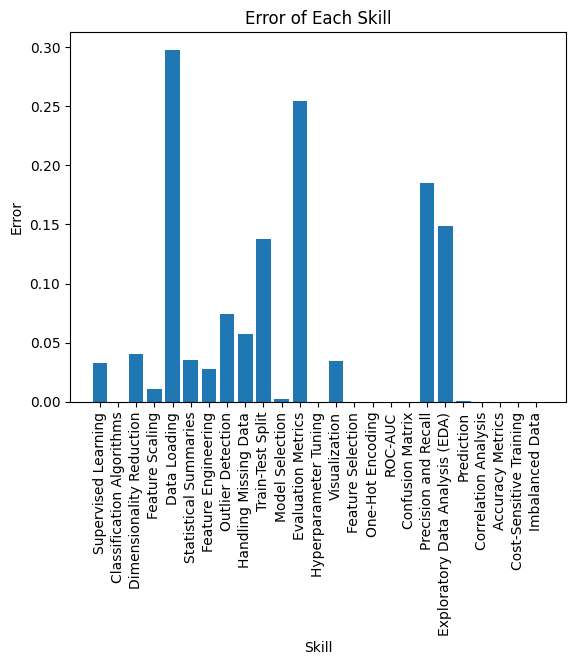

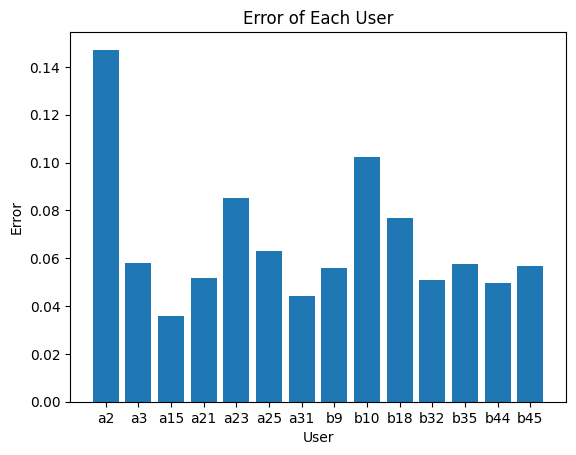

In [93]:
# compute the correctness probability for test cases
from sklearn.metrics import roc_curve, roc_auc_score

test_likelihood, results, error_skill, error_user = test_log_likelihood(test_df, skill_params)
output = [x[2] for x in results]
labels = [x[3] for x in results]

# create AUROC curve for different theresholds
fpr, tpr, thresholds = roc_curve(labels, output)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# compute the confusion matrix for specific threshold
thresholds = 0.5
predictions = [1 if x > thresholds else 0 for x in output]
confusion_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'))
print(confusion_matrix)

# compute the AUC score
auc = roc_auc_score(labels, output)
print(f"AUC: {auc}")

# compute the accuracy, F1 score, precision, and recall
TP = confusion_matrix[1][1]
TN = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]

# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# plot the histogram of output - labels
error = np.array(labels) - np.array(output)
plt.figure()
plt.hist(error, bins=20)
plt.xlabel('Error ')
plt.ylabel('Frequency')
plt.title('Error = labels - output')


# compute the overal MSE
print("MSE: ", np.mean(np.array(error)**2))

# plot the error of each skill
plt.figure()
plt.bar(error_skill.keys(), error_skill.values())
plt.ylabel('Error')
# rotate the x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Skill')
plt.title('Error of Each Skill')
plt.show()


# plot the error of each user
plt.figure()
plt.bar(error_user.keys(), error_user.values())
plt.ylabel('Error')
# rotate the x-axis labels
plt.xlabel('User')
plt.title('Error of Each User')
plt.show()
